# 📊 Quantitative analysis of a stock: Performance & Risk Analysis

This project is a comprehensive quantitative analysis of a single stock compared to a benchmark. The goal is to refine my Python skills in financial data analysis while building a reusable framework for evaluating assets.

The analysis covers:
- Historical performance vs benchmark
- Risk-adjusted return metrics (Sharpe, Sortino, Calmar, etc.)
- Statistical properties of returns (mean, std, skewness, kurtosis)
- Risk assessment (VaR, CVaR, drawdowns, beta)
- Normality tests and return distribution analysis
- Rolling metrics and visualizations
This is not investment advice — it’s a personal learning project aimed at combining finance theory with practical Python implementation.

More from me:

- [My socials](https://whispering-cricket-3c5.notion.site/Link-in-Bio-1979bd8bfc31804d8d2fd633cb1a891c?source=copy_link)

- [My website](https://nicolasponcin.com)

Are you a recruiter ? Here is my [CV](https://whispering-cricket-3c5.notion.site/Nicolas-Poncin-CV-1979bd8bfc318006a04ef40ed5bde371?source=copy_link)



In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

from scipy import stats
from scipy.stats import norm

import yfinance as yf

## Data Import

Here, we download historical data for a stock (JPM) and the benchmark (SPY) using Yahoo Finance. We also define the risk-free rate and compute the number of years covered in the dataset for annualization purposes.

In [56]:
# Define start and end dates for data extraction
start = '2000-01-01'
end = '2025-08-12'

# Download JPMorgan stock data
jpm = yf.download('JPM', start=start, end=end)

# Download benchmark (S&P 500 ETF - SPY)
spy = yf.download('SPY', start=start, end=end)

# Define the annual risk-free rate (approximation)
rf = .02

# Define significance level (alpha) for risk metrics
alpha = 0.05

# Calculate the number of observed years (used for annualization)
years = (jpm.index[-1] - jpm.index[0]).days / 365.25
print("\n\nYears of data:", years)

/tmp/ipython-input-680848906.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  jpm = yf.download('JPM', start=start, end=end)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-680848906.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy = yf.download('SPY', start=start, end=end)
[*********************100%***********************]  1 of 1 completed



Years of data: 25.60438056125941


## Price and Return Calculations

### Daily Returns

Daily returns represent the simple percentage change in the closing price from one day to the next.

In [57]:
def daily_ret(asset):
    return asset['Close'].pct_change(1)[1:]

jpm_daily_return = daily_ret(jpm)
spy_daily_return = daily_ret(spy)

### Logarithmic Returns

Logarithmic returns are additive over time, making them more suitable for statistical modeling and time series analysis.

In [58]:
def log_ret(asset):
    return np.log(asset['Close']/asset['Close'].shift(1))[1:]

jpm_log_return = log_ret(jpm)
spy_log_return = log_ret(spy)

### Normalized Returns

Normalized returns allow us to compare the growth of two assets starting from the same base value, which helps visualize relative performance.

In [59]:
def normed_ret(asset):
    return asset['Close'] / asset['Close'].iloc[0]

jpm_normed_price = normed_ret(jpm)
spy_normed_price = normed_ret(spy)

## Description

### Functions

In [60]:
#Mean/Total/Std returns
#def mean_std_total_return(daily_return):
#    mean = daily_return.mean()
#    std = daily_return.std()
#    total_return = daily_return.iloc[-1]/daily_return.iloc[0] - 1
#    return mean, std, total_return

# Sharp ratio
def sharp_ratio(daily_return, risk_free_rate):
    daily_rf = (1 + risk_free_rate) ** (1/252) - 1
    daily_sharp = (daily_return.mean() - daily_rf) / daily_return.std()
    sharp = daily_sharp * np.sqrt(252)
    return sharp

# Sortino ratio
def sortino_ratio(daily_returns, risk_free_rate, target=0):
    # Rendement annualisé
    mean_ann = daily_returns.mean() * 252
    # Downside deviation
    downside = np.where(daily_returns < target, daily_returns - target, 0)
    downside_dev_daily = np.sqrt(np.mean(downside**2))
    downside_dev_ann = downside_dev_daily * np.sqrt(252) #Annualisation du downside deviation
    # Sortino
    sortino = (mean_ann - risk_free_rate) / downside_dev_ann
    return sortino

# Correlation of returns
def corr_ret(daily_ret, daily_ret_b):
    # Convertir en array pour éviter les problèmes de DataFrame
    x = daily_ret.values.flatten()
    y = daily_ret_b.values.flatten()

    # Corrélation
    corr = np.corrcoef(x, y)[0,1]
    # Scatter plot
    plt.figure(figsize=(6,6))
    plt.scatter(x, y, alpha=0.5)

    # Droite de régression
    m, b = np.polyfit(x, y, 1)
    plt.plot(x, m*x + b, color="red")

    plt.title(f"Corrélation des rendements (ρ = {corr:.2f})")
    plt.xlabel("Stock Returns")
    plt.ylabel("Benchmark Returns")
    plt.grid(True)

    print(f"Correlation of returns: {corr:.4f}\n")

    plt.show()



### Mean/total returns, std

Asset vs Benchmark

In [61]:
# Daily mean return
jpm_mean_return = jpm_daily_return.mean()
spy_mean_return = spy_daily_return.mean()
print(f'Mean return: {jpm_mean_return.iloc[0]*100:.2f}% vs {spy_mean_return.iloc[0]*100:.2f}%')

# Std
jpm_std_return = jpm_daily_return.std()
spy_std_return = spy_daily_return.std()
print(f'Std return: {jpm_std_return.iloc[0]*100:.2f}% vs {spy_std_return.iloc[0]*100:.2f}%')

# Total return
jpm_total_return = jpm['Close'].iloc[-1]/jpm['Close'].iloc[0] - 1
spy_total_return = spy['Close'].iloc[-1]/spy['Close'].iloc[0] - 1
print(f'Total return: {jpm_total_return.iloc[0]*100:.2f}% vs {spy_total_return.iloc[0]*100:.2f}%')

Mean return: 0.07% vs 0.04%
Std return: 2.34% vs 1.23%
Total return: 1152.11% vs 590.15%


### Sharp & Sortino ratio

Asset vs Benchmark

In [62]:
# Sharp ratio
jpm_sharp_ratio = sharp_ratio(jpm_daily_return, rf)
spy_sharp_ratio = sharp_ratio(spy_daily_return, rf)
print(f'Sharp ratio: {jpm_sharp_ratio.iloc[0]:.2f} vs {spy_sharp_ratio.iloc[0]:.2f}')

# Sortino Ration (based on rf)
jpm_sortino_ratio = sortino_ratio(jpm_daily_return, rf)
spy_sortino_ratio = sortino_ratio(spy_daily_return, rf)
print(f'Sortino ratio: {jpm_sortino_ratio.iloc[0]:.2f} vs {spy_sortino_ratio.iloc[0]:.2f}')

Sharp ratio: 0.40 vs 0.38
Sortino ratio: 0.60 vs 0.54


### Correlation of returns

Correlation of returns: 0.7174



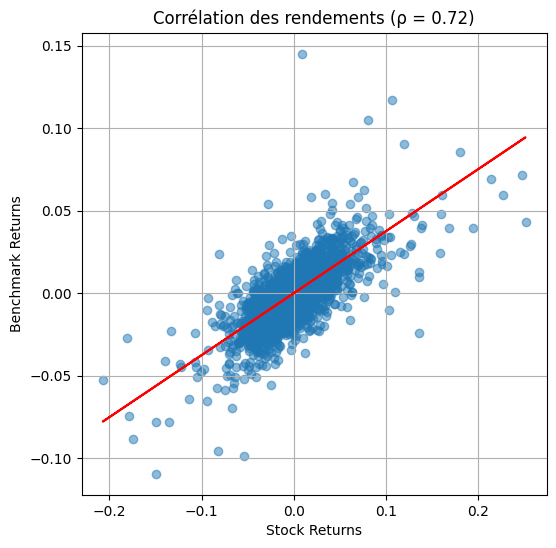

In [63]:
corr_ret(jpm_daily_return, spy_daily_return)

## Charts analysis

### Functions

In [64]:
# Price chart
def price_chart(stock_normed_price, benchmark_normed_price):
    plt.figure(figsize=(10,6))
    plt.plot(stock_normed_price, label='Stock')
    plt.plot(benchmark_normed_price, label='Benchmark')
    plt.title('Price chart: stock vs benchmark')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()


# Histograms Comparison
def hist_ret_comp(daily_ret, daily_ret_b):
    fig, axes = plt.subplots(1, 3, figsize=(17, 6), sharey=True, sharex=True)

    # --- Subplot 1 : Stock ---
    axes[0].hist(daily_ret, bins=50, density=True, color="skyblue", edgecolor="black", alpha=0.6)
    axes[0].set_title("Distribution des rendements - Stock")
    axes[0].set_xlabel("Daily Return")
    axes[0].set_ylabel("Density")

    # --- Subplot 2 : Benchmark ---
    axes[1].hist(daily_ret_b, bins=50, density=True, color="red", edgecolor="black", alpha=0.6)
    axes[1].set_title("Distribution des rendements - Benchmark")
    axes[1].set_xlabel("Daily Return")

    # --- Subplot 3 : Comparison ---
    axes[2].hist(daily_ret, bins=50, density=True, color="skyblue", edgecolor="black", alpha=0.8)
    axes[2].hist(daily_ret_b, bins=50, density=True, color="red", edgecolor="black", alpha=0.4)
    axes[2].set_title("comparison of returns")
    axes[2].set_xlabel("Daily Return")

    plt.tight_layout()
    plt.show()


# KDE Comparison
def kde_comp(daily_ret, daily_ret_b):
    fig, axes = plt.subplots(1, 3, figsize=(17, 6), sharey=True, sharex=True)

    # --- Subplot 1 : Stock ---
    daily_ret.plot(kind="kde", color="blue", label="Stock", ax=axes[0])
    axes[0].set_title("KDE - Stock")
    axes[0].set_xlabel("Daily Return")
    axes[0].set_ylabel("Density")

    # --- Subplot 2 : Benchmark ---
    daily_ret_b.plot(kind="kde", color="red", label="Benchmark", ax=axes[1])
    axes[1].set_title("KDE - Benchmark")
    axes[1].set_xlabel("Daily Return")

    # --- Subplot 3 : Comparison ---
    daily_ret.plot(kind="kde", color="blue", label="Stock", ax=axes[2])
    daily_ret_b.plot(kind="kde", color="red", label="Benchmark", ax=axes[2])
    axes[2].set_title("Comparison of KDEs")
    axes[2].set_xlabel("Daily Return")
    axes[2].legend()

    plt.tight_layout()
    plt.show()



### Price chart

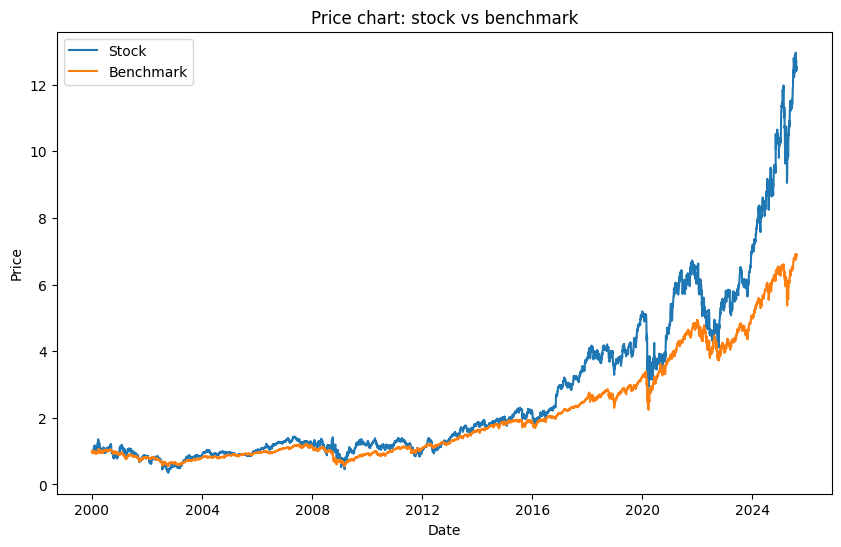

In [65]:
price_chart(jpm_normed_price, spy_normed_price)

### Return distribution

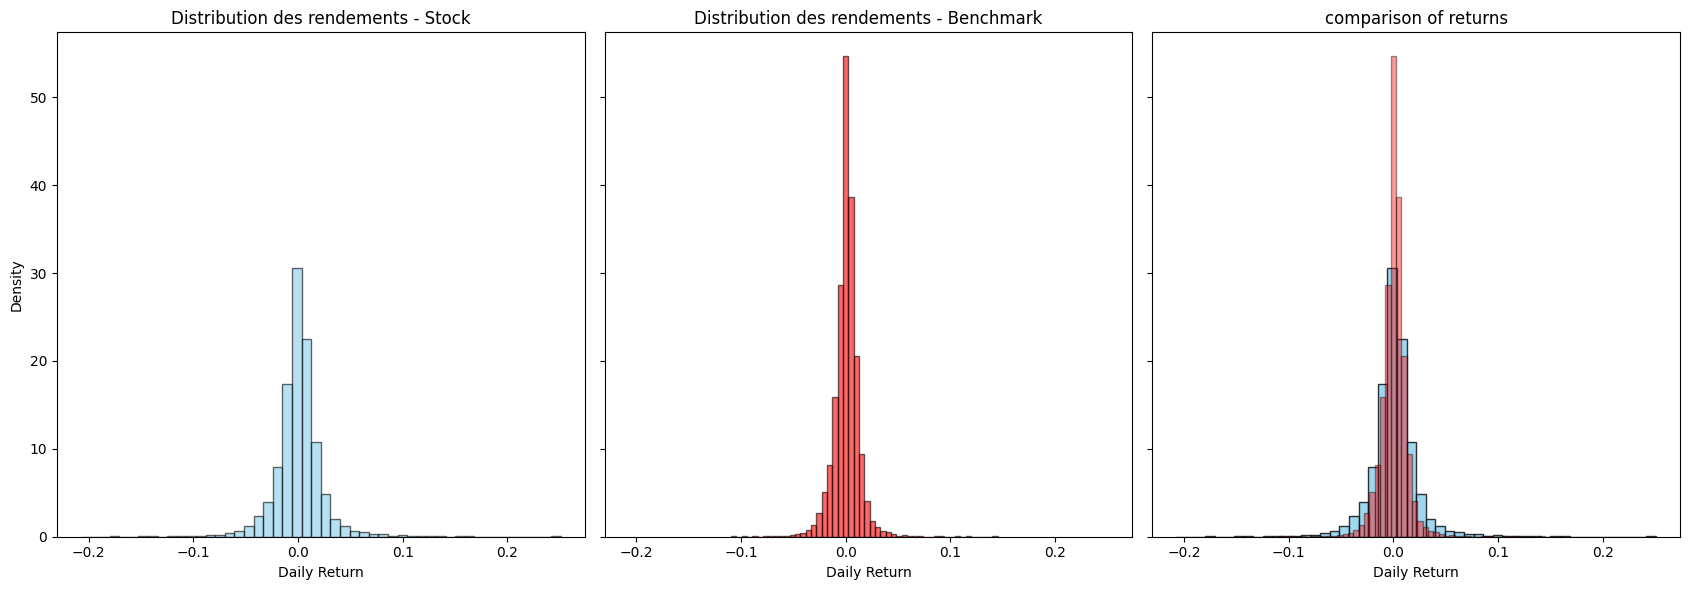

In [66]:
hist_ret_comp(jpm_daily_return, spy_daily_return)


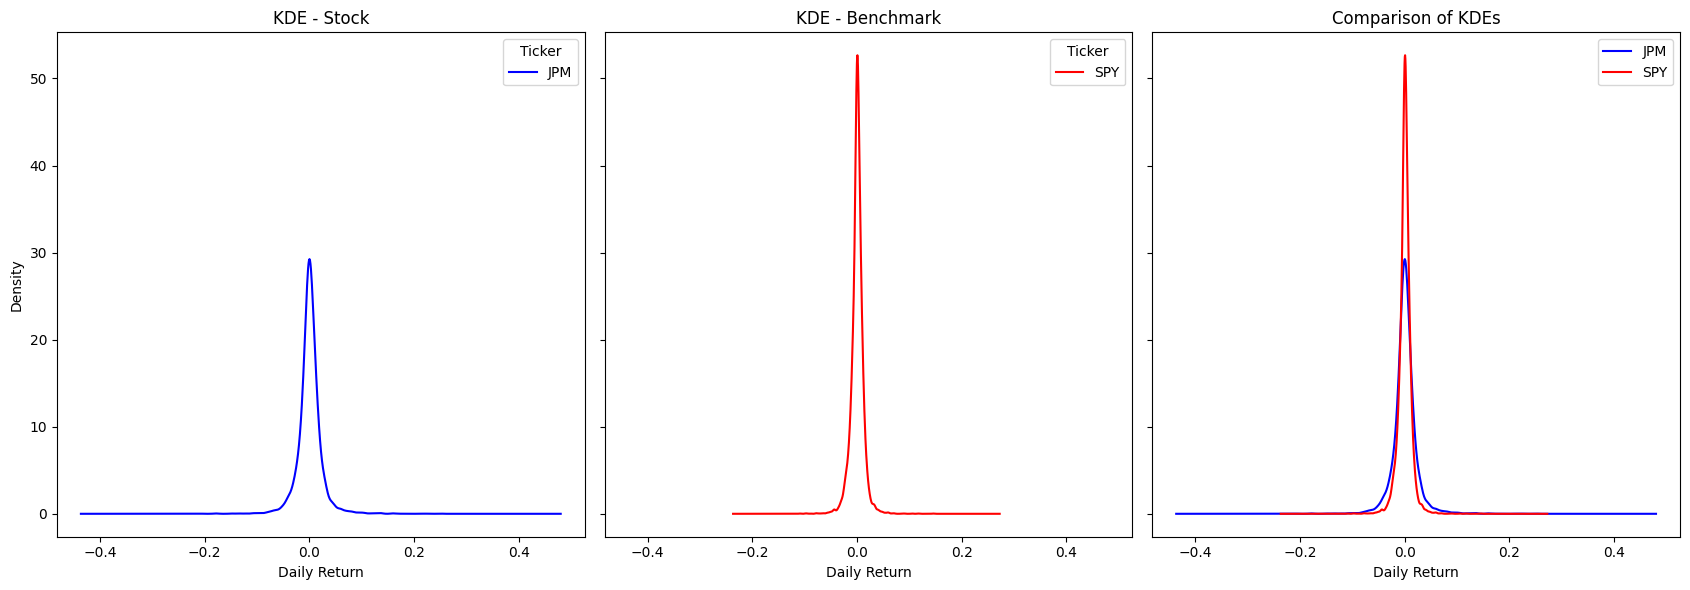

In [67]:
kde_comp(jpm_daily_return, spy_daily_return)

## Risk Analysis

### Functions

In [68]:
# Lower partial momentums
def lower_partial_moment(log_returns, threshold=0.0, order=2):
    diff = threshold - log_returns
    if order == 0:
      return np.mean(log_returns < threshold)
    else:
      downside = np.where(diff > 0, diff, 0)
      return np.mean(downside**order)

# Max drawdown (value & duration)
def max_drawdown_duration(normed_price):
    # convertion in series if necessary
    normed_price = normed_price.squeeze()
    roll_max = normed_price.cummax()
    drawdown = normed_price / roll_max - 1
    # Max dd
    drawdown_max = drawdown.min()
    # end
    end_date = drawdown.idxmin()
    # start
    start_date = normed_price[:end_date][normed_price[:end_date] == roll_max[:end_date]].index[-1]
    # length (days)
    duration = (end_date - start_date).days
    return {
        "drawdown_max": drawdown_max,
        "start_date": start_date,
        "end_date": end_date,
        "duration_days": duration}

# Max drawdown date
def max_drawdown_date(normed_price):
    roll_max = normed_price.cummax()
    drawdown = (normed_price / roll_max - 1)
    return drawdown.idxmin() # date du plus gros drawdown

# Max drawdown Chart
def dd_chart(stock_normed_price, benchmark_normed_price):
    plt.figure(figsize=(10,6))
    plt.plot(stock_normed_price, label='Stock')
    plt.plot(benchmark_normed_price, label='Benchmark')

    # Define start and end dates for data extractions des max DD
    stock_dd_date = max_drawdown_date(stock_normed_price)
    bench_dd_date = max_drawdown_date(benchmark_normed_price)

    # Red lines
    plt.axvline(stock_dd_date, color='red', linestyle='--', label='Max DD Stock')
    plt.axvline(bench_dd_date, color='orange', linestyle='--', label='Max DD Benchmark')

    plt.title('Price chart: Stock vs Benchmark (with Max DD dates)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

    print(f"Max drawdown date of the stock: {stock_dd_date} Max drawdown date of the stock: {bench_dd_date}")


# Calmar Ratio
def calmar_ratio(prices, max_dd, years):
    cagr = (prices['Close'].iloc[-1] / prices['Close'].iloc[0])**(1/years) - 1
    return cagr / abs(max_dd)


# Parametric VaR
def parametric_var(returns, alpha=0.05):
    mu = returns.mean()
    sigma = returns.std()
    var = mu + norm.ppf(alpha) * sigma
    return var

# Plot VaR
def plot_var(ax, returns, var, alpha, label, zoom=True):
    returns = returns.squeeze() if isinstance(returns, pd.DataFrame) else returns
    var = var.item() if isinstance(var, pd.Series) else var

    ax.hist(returns, bins=50, density=True, color='skyblue', edgecolor="black", alpha=0.8 )
    ax.axvline(var, color='red', linestyle='--', linewidth=1, label=f"VaR {alpha*100:.1f}%")
    ax.axvspan(xmin=returns.min(), xmax=var, color='red', alpha=0.15)

    # Zoom option
    if zoom:
        ax.set_xlim(var - 0.05 , 0.1 )

    ax.set_title(f'{label} - Parametric VaR ({alpha*100:.1f}%)')
    ax.set_xlabel('Returns')
    ax.set_ylabel('Frequency')
    ax.legend()


# Conditional VaR (CVaR / Expected Shortfall)
def conditional_var(returns, alpha=0.05):
    """
    Parametric Conditional VaR using Normal distribution
    """
    returns = returns.squeeze() if isinstance(returns, pd.DataFrame) else returns
    mu = returns.mean()
    sigma = returns.std()
    var = mu + norm.ppf(alpha) * sigma
    # CVaR formule paramétrique : ES = mu - sigma * pdf(z_alpha)/alpha
    z = norm.ppf(alpha)
    cvar = mu - sigma * norm.pdf(z)/alpha
    return cvar

# Plot CVaR
def plot_cvar(ax, returns, cvar, alpha, label, zoom=True):
    returns = returns.squeeze() if isinstance(returns, pd.DataFrame) else returns
    cvar = cvar.item() if isinstance(cvar, pd.Series) else cvar

    ax.hist(returns, bins=50, density=True, color='skyblue', edgecolor="black", alpha=0.8)
    ax.axvline(cvar, color='red', linewidth=2, label=f"CVaR {alpha*100:.1f}%")

    # Zoom option
    if zoom:
        ax.set_xlim(cvar - 0.05 , 0.1)

    ax.set_title(f'{label} - Conditional VaR ({alpha*100:.1f}%)')
    ax.set_xlabel('Returns')
    ax.set_ylabel('Density')
    ax.legend()


### Lower partial momentums

In [69]:
lpm_0 = lower_partial_moment(jpm_log_return, threshold=0, order=0)
lpm_1 = lower_partial_moment(jpm_log_return, threshold=0, order=1)
lpm_2 = lower_partial_moment(jpm_log_return, threshold=0, order=2)

print(f"LPM(0): {lpm_0*100:.4f}% - Probability of a loss\nLPM(1): {lpm_1*100:.4f}% - Average Loss if returns are negative\nLPM(2): {lpm_2*100:.4f}% - Downside volatility")


LPM(0): 48.5169% - Probability of a loss
LPM(1): 0.7102% - Average Loss if returns are negative
LPM(2): 0.0259% - Downside volatility


In [70]:
lpm_0 = lower_partial_moment(spy_log_return, threshold=0, order=0)
lpm_1 = lower_partial_moment(spy_log_return, threshold=0, order=1)
lpm_2 = lower_partial_moment(spy_log_return, threshold=0, order=2)

print(f"LPM(0): {lpm_0*100:.4f}% - Probability of a loss\nLPM(1): {lpm_1*100:.4f}% - Average Loss if returns are negative\nLPM(2): {lpm_2*100:.4f}% - Downside volatility")


LPM(0): 45.2089% - Probability of a loss
LPM(1): 0.3907% - Average Loss if returns are negative
LPM(2): 0.0078% - Downside volatility


### Max drawdowns

In [71]:
stock_dd_info = max_drawdown_duration(jpm_normed_price)
bench_dd_info = max_drawdown_duration(spy_normed_price)

print(f"JPM Max DD: {stock_dd_info['drawdown_max']:.2%}, Duration: {stock_dd_info['duration_days']} days, "
      f"From {stock_dd_info['start_date']} to {stock_dd_info['end_date']}")

print(f"SPY Max DD: {bench_dd_info['drawdown_max']:.2%}, Duration: {bench_dd_info['duration_days']} days, "
      f"From {bench_dd_info['start_date']} to {bench_dd_info['end_date']}")

JPM Max DD: -74.02%, Duration: 930 days, From 2000-03-23 00:00:00 to 2002-10-09 00:00:00
SPY Max DD: -55.19%, Duration: 517 days, From 2007-10-09 00:00:00 to 2009-03-09 00:00:00


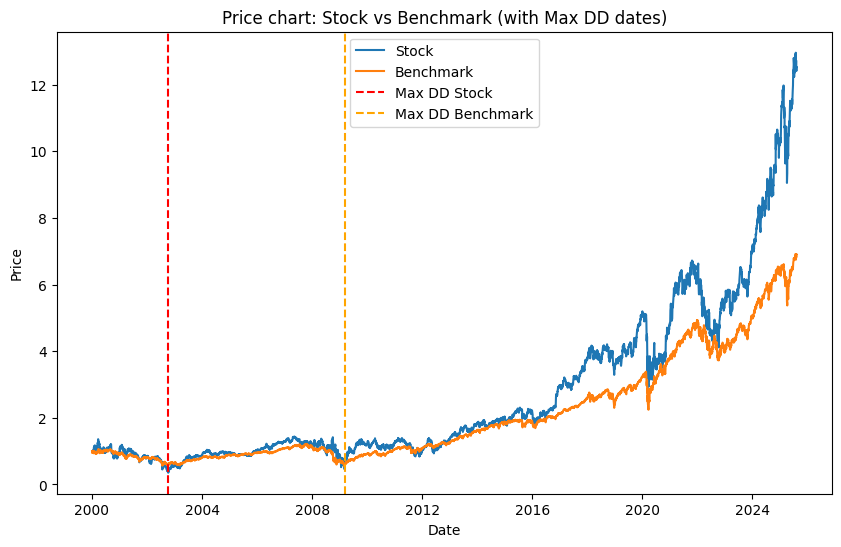

Max drawdown date of the stock: Ticker
JPM   2002-10-09
dtype: datetime64[ns] Max drawdown date of the stock: Ticker
SPY   2009-03-09
dtype: datetime64[ns]


In [72]:
dd_chart(jpm_normed_price, spy_normed_price)


### Calmar ratio

The Calmar Ratio measures an investment’s risk-adjusted performance by comparing its annualized return (CAGR) to its maximum drawdown. A higher ratio indicates better returns relative to the worst loss experienced.

In [73]:
calmar_ratio_jpm = calmar_ratio(jpm, stock_dd_info['drawdown_max'], years)
calmar_ratio_spy = calmar_ratio(spy, bench_dd_info['drawdown_max'], years)
print(f"Calmar ratio of : {calmar_ratio_jpm}% vs {calmar_ratio_spy}%")

Calmar ratio of : Ticker
JPM    0.140159
dtype: float64% vs Ticker
SPY    0.141992
dtype: float64%


Here, for every 1% of maximum loss the investment experienced, it generated about 0.14% of annualized return—so higher ratios indicate better return relative to the worst drawdown.

### Value at Risk

#### Parametric VaR

In [74]:
jpm_var = parametric_var(jpm_daily_return, alpha)
spy_var = parametric_var(spy_daily_return, alpha)

print(f"Parametric VaR (JPM) at {alpha*100:.1f}%: {jpm_var.iloc[0]:.4%}\nWith {alpha*100}% confidence, your daily loss will not exceed {jpm_var.iloc[0]:.4%}")
print(f"\nParametric VaR (SPY) at {alpha*100:.1f}%: {spy_var.iloc[0]:.4%}\nWith {alpha*100}% confidence, your daily loss will not exceed {spy_var.iloc[0]:.4%}")

Parametric VaR (JPM) at 5.0%: -3.7864%
With 5.0% confidence, your daily loss will not exceed -3.7864%

Parametric VaR (SPY) at 5.0%: -1.9822%
With 5.0% confidence, your daily loss will not exceed -1.9822%


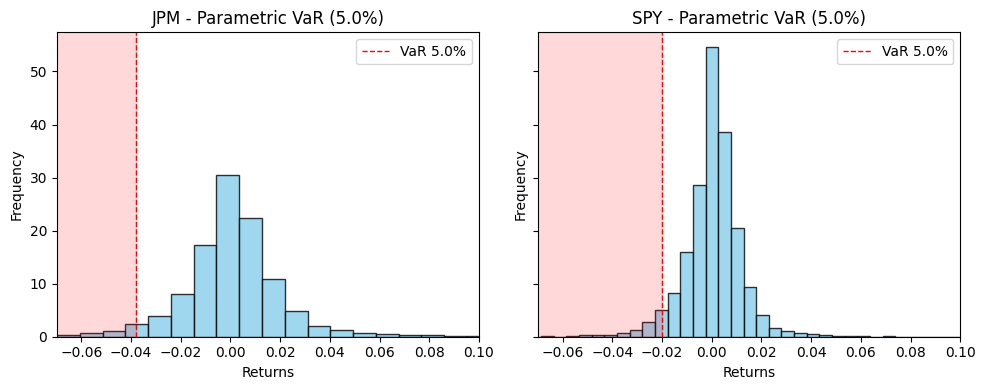

In [75]:
fig, axes = plt.subplots(1, 2, figsize=(10,4), sharex=True, sharey=True)

plot_var(axes[0], jpm_daily_return, jpm_var, alpha, "JPM", zoom=True)
plot_var(axes[1], spy_daily_return, spy_var, alpha, "SPY", zoom=True)

plt.tight_layout()
plt.show()

#### Conditional VaR

In [76]:
jpm_cvar = conditional_var(jpm_daily_return, alpha)
spy_cvar = conditional_var(spy_daily_return, alpha)

print(f"Conditional VaR (JPM) at {alpha*100:.1f}%: {jpm_cvar:.4%}\nAverage loss of approximately {-jpm_cvar:.4%} in the worst {--alpha}% of cases.\n")
print(f"\nConditional VaR (SPY) at {alpha*100:.1f}%: {spy_cvar:.4%}\nAverage loss of approximately {-spy_cvar:.4%} in the worst {--alpha}% of cases.")

Conditional VaR (JPM) at 5.0%: -4.7652%
Average loss of approximately 4.7652% in the worst 0.05% of cases.


Conditional VaR (SPY) at 5.0%: -2.4952%
Average loss of approximately 2.4952% in the worst 0.05% of cases.


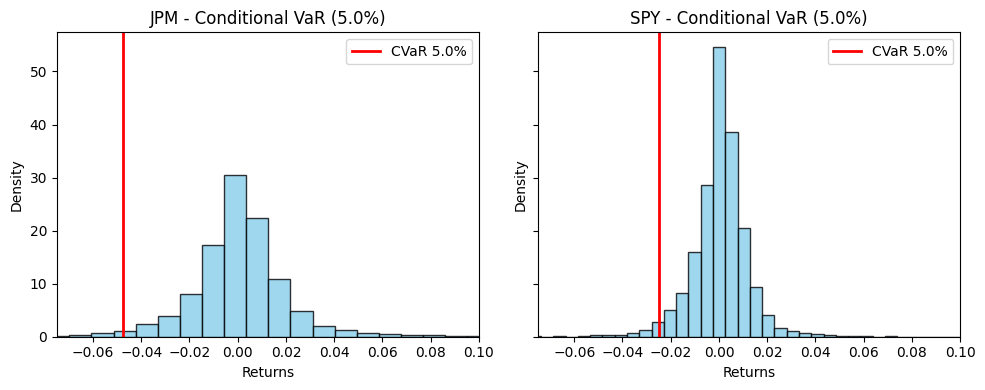

In [77]:
fig, axes = plt.subplots(1, 2, figsize=(10,4), sharex=True, sharey=True)

plot_cvar(axes[0], jpm_daily_return, jpm_cvar, alpha, "JPM", zoom=True)
plot_cvar(axes[1], spy_daily_return, spy_cvar, alpha, "SPY", zoom=True)

plt.tight_layout()
plt.show()

#### Summary

/tmp/ipython-input-2320400783.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ax.axvspan(xmin=float(var), xmax=returns.squeeze().max(), color='green', alpha=0.15)


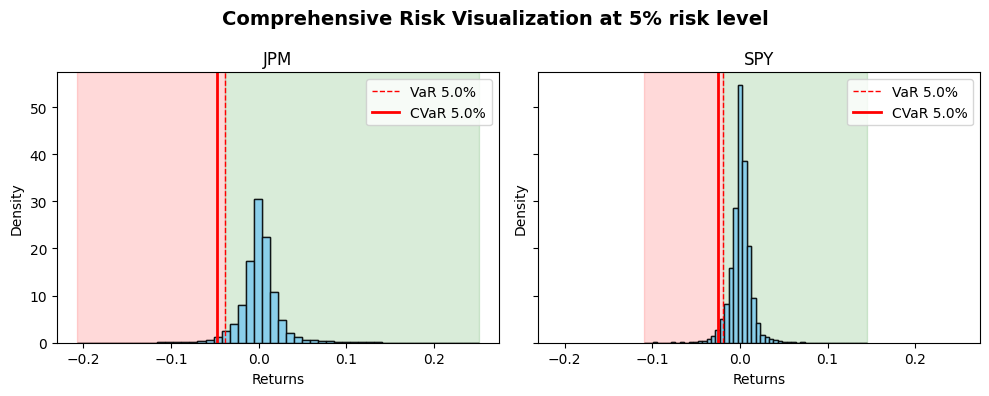

In [78]:
fig, axes = plt.subplots(1, 2, figsize=(10,4), sharex=True, sharey=True)

for ax, returns, var, cvar, label in zip(
    axes,
    [jpm_daily_return, spy_daily_return],
    [jpm_var, spy_var],
    [jpm_cvar, spy_cvar],
    ["JPM", "SPY"]):

    # GreenZone (1-alpha% of the cases)
    ax.axvspan(xmin=float(var), xmax=returns.squeeze().max(), color='green', alpha=0.15)
    # VaR
    plot_var(ax, returns, var, alpha, label, zoom=False)
    # CVaR
    plot_cvar(ax, returns, cvar, alpha, label, zoom=False)

    ax.set_title(f'{label}')

fig.suptitle(f'Comprehensive Risk Visualization at {alpha*100:.0f}% risk level', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## CAPM

### Functions

In [79]:
#Capital Asset Pricing Model (stock vs benchmark)
def CAPM(stock_daily_return, benchmark_daily_return, rf_daily):
    x = (benchmark_daily_return - rf_daily)
    y = (stock_daily_return - rf_daily)
    beta, alpha, r_value, p_value, std_err = stats.linregress(x, y)
    r2 = r_value**2
    return beta, alpha, r_value, p_value, std_err

#CAPM (stock vs noised benchmark)
def CAPM_noise(stock_daily_return, benchmark_daily_return, rf_daily):
    #Noise
    noise = np.random.normal(0,0.1*benchmark_daily_return.std(), len(benchmark_daily_return))   # noise = 10% of market volatility
    noised_market = benchmark_daily_return + pd.Series(noise, index=benchmark_daily_return.index)
    #CAPM
    beta_noised, alpha_noised, r_value_noised, p_value_noised, std_err_noised = CAPM(stock_daily_return, noised_market, rf_daily)
    r2_noised = r_value_noised**2
    return beta_noised, alpha_noised, r_value_noised, p_value_noised, std_err_noised


### Stock vs Market

Note: Alpha is daily, and needs to be annualized.

In [80]:
rf_d = rf / 252
beta, alpha, r_value, p_value, std_err = CAPM(jpm_daily_return.squeeze(), spy_daily_return.squeeze(), rf_d)


print(f"Beta: {beta:.4f}\nAlpha: {alpha:.4f}\nR-value: {r_value**2:.4f}\np-value: {p_value:.4f}\nStd err: {std_err:.4f}")
print(f"Alpha annualized: {alpha*252:.4f}")

Beta: 1.3685
Alpha: 0.0002
R-value: 0.5146
p-value: 0.0000
Std err: 0.0166
Alpha annualized: 0.0454


### Stock vs noised Market

In [81]:
beta_noised, alpha_noised, r_value_noised, p_value_noised, std_err_noised = CAPM_noise(jpm_daily_return.squeeze(), spy_daily_return.squeeze(), rf_d)


print(f"Beta: {beta_noised:.4f}\nAlpha: {alpha_noised:.4f}\nR-value: {r_value_noised**2:.4f}\np-value: {p_value_noised:.4f}\nStd err: {std_err_noised:.4f}")
print(f"Alpha annualized: {alpha_noised*252:.4f}")

Beta: 1.3527
Alpha: 0.0002
R-value: 0.5092
p-value: 0.0000
Std err: 0.0166
Alpha annualized: 0.0406


## Tracking Error

⚠️ Tracking error doesn’t tell if we outperform/underperform the benchmark; it’s just a measure of relative volatility.

Low tracking error (0–2%) → portfolio closely follows the benchmark.

Moderate tracking error (2–5%) → small active risk taken.

High tracking error (>5–6%) → large deviation from the benchmark, very active or volatile portfolio.



### Function

In [84]:
# Tracking Error
def tracking_error(stock_returns, benchmark_returns, annualize=True):
    active_returns = stock_returns - benchmark_returns
    te_daily = active_returns.std()
    #annualize if necessary
    if annualize:
        te = te_daily * np.sqrt(252)
    else:
        te = te_daily
    return te

### Tracking Error

In [85]:
def rolling_te(stock_normed_price, benchmark_normed_price, stock_daily_returns, benchmark_daily_returns):
    # Rolling TE (annualized)
    rolling_te = (stock_daily_returns - benchmark_daily_returns).rolling(252).std() * np.sqrt(252)

    #Plot
    fig, axes = plt.subplots(1, 2, figsize=(16,6), sharey=False)
    # Left: Rolling TE only
    axes[0].plot(rolling_te, color='g', label='Rolling TE (annualized)')
    axes[0].set_title('Rolling Tracking Error: JPM vs SPY')
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('Tracking Error (annualized)')
    axes[0].grid(True)
    axes[0].legend()
    # Right: Prices + Rolling TE
    ax1 = axes[1]
    ax1.plot(stock_normed_price, color='blue', label='JPM Price')
    ax1.plot(benchmark_normed_price, color='orange', label='SPY Price')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Normalized Price')
    ax1.legend(loc='upper left')
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.plot(rolling_te, color='green', label='Rolling TE (annualized)')
    ax2.set_ylabel('Tracking Error (annualized)')
    ax2.legend(loc='upper right')

    axes[1].set_title('JPM vs SPY: Prices and Rolling Tracking Error')

    plt.tight_layout()
    plt.show()


In [86]:
te_jpm = tracking_error(jpm_daily_return.squeeze(), spy_daily_return.squeeze())

print(f"Tracking Error JPM vs SPY (annualized): {te_jpm:.4%}\n\nJPM’s daily returns deviate on average by {te_jpm:.1%} per year from SPY.")

Tracking Error JPM vs SPY (annualized): 26.8829%

JPM’s daily returns deviate on average by 26.9% per year from SPY.


### Plot

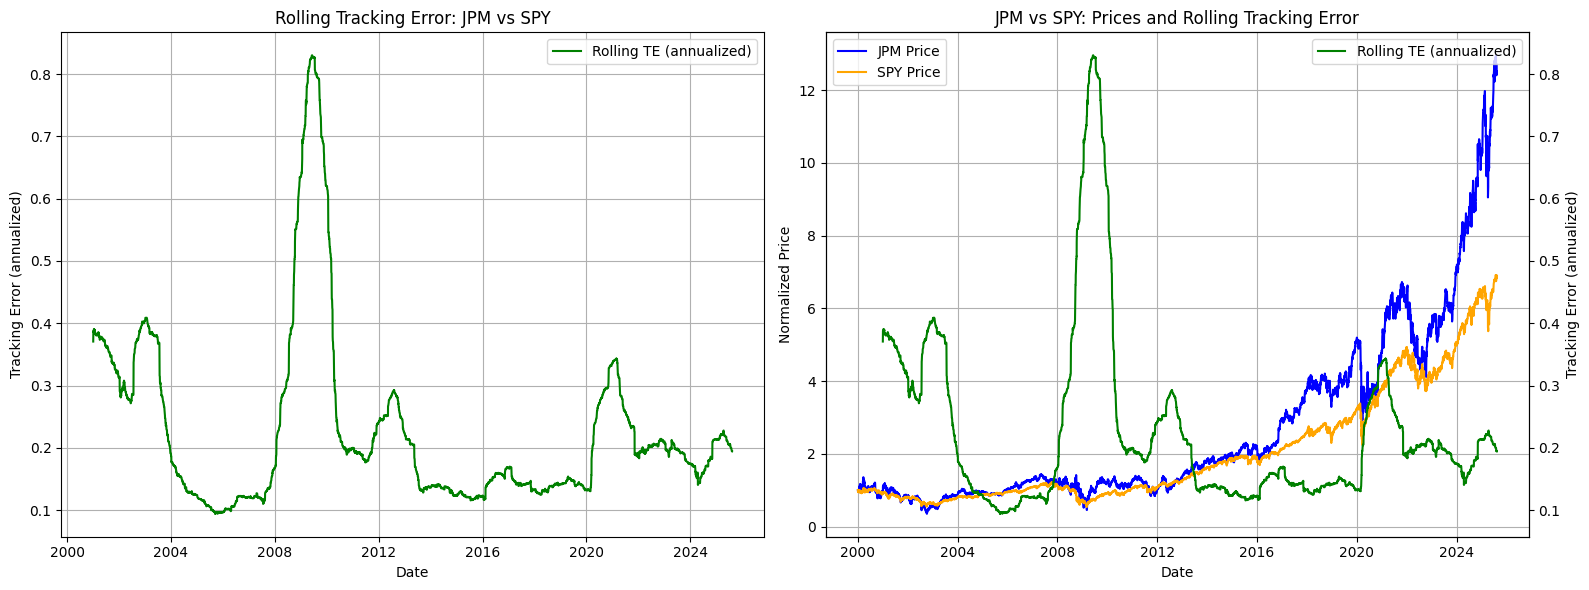

In [88]:
rolling_te(jpm_normed_price, spy_normed_price, jpm_daily_return.squeeze(), spy_daily_return.squeeze())


## Price prediction (ARIMA)

This part isn’t functional. It was mainly an exercise to refine my coding skills and better understand the ARIMA model. It doesn’t work because ARIMA is not suitable for predicting stock markets, as financial time series are highly non-stationary, noisy, and influenced by external factors that the model cannot capture.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

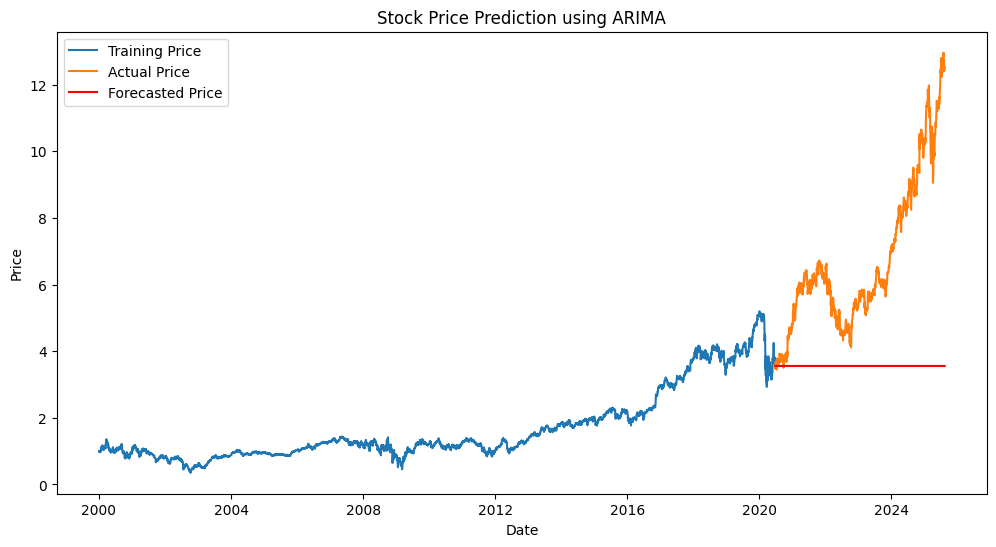

In [87]:
# Convert price series to log scale using the normalized price
series_log = np.log(jpm_normed_price.squeeze())

# Split data into training and testing sets
train_size = int(len(series_log) * 0.8) # 80% for training
train, test = series_log[0:train_size], series_log[train_size:]

# Fit ARIMA model on the training data
# Order (p, d, q) parameters. For demonstration, let's use a simple order (5,1,0).
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()

# Make forecast for the length of the test set
forecast_steps = len(test)
forecast = model_fit.forecast(steps=forecast_steps)

# Convert forecast back to original price scale
forecast_price = np.exp(forecast)

# Convert test data back to original price scale for comparison
test_price = np.exp(test)

# Set the index of the forecasted price to match the index of the test price
forecast_price.index = test_price.index


# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(np.exp(train), label='Training Price') # Plot training data in original scale
plt.plot(test_price, label='Actual Price')
plt.plot(forecast_price, label='Forecasted Price', color='red')
plt.title('Stock Price Prediction using ARIMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()